In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    LeaveOneOut,
    GridSearchCV,
    cross_val_score
)

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

RANDOM_STATE = 42

In [ ]:
# Данные: мультиклассовая классификация (вино: 3 сорта)
# TODO: взять другие данные (большего размера)
X, y = load_wine(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

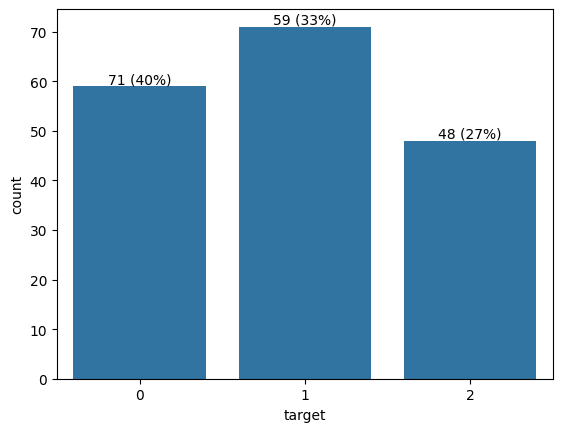

In [12]:
ax = sns.countplot(x=y)

abs_values = y.value_counts(ascending=False)
rel_values = y.value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)
plt.show()

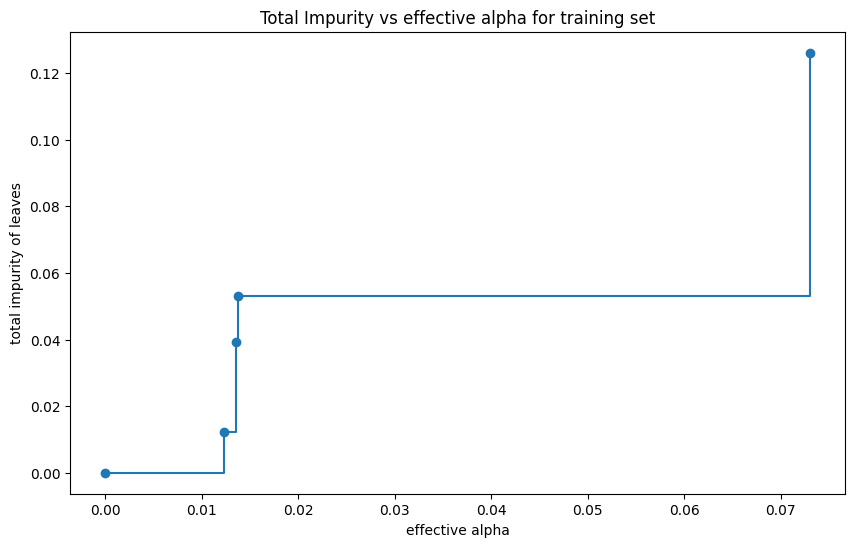

In [13]:
tmp_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
path = tmp_tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [14]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2657997407682344


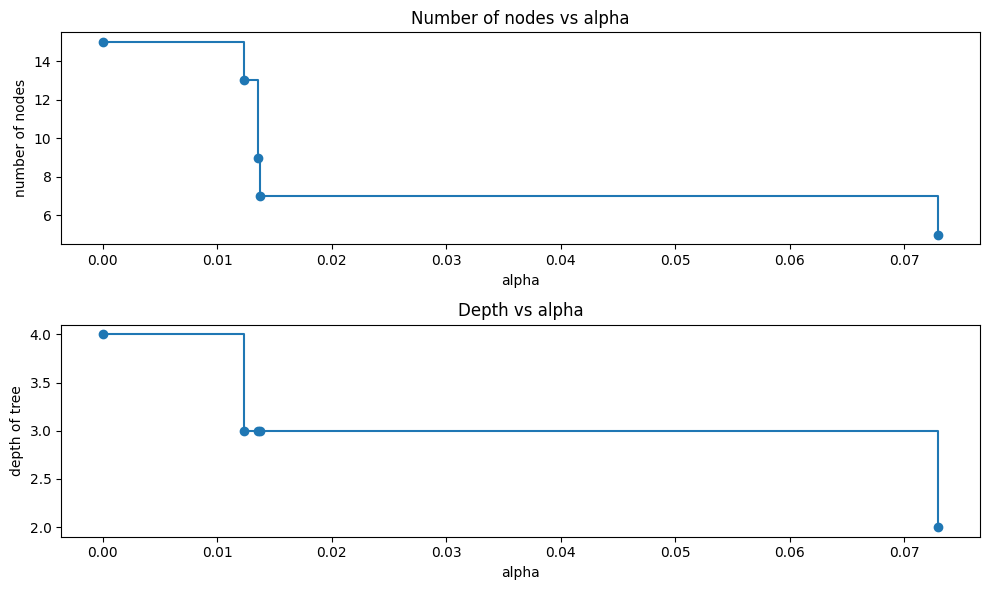

In [15]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

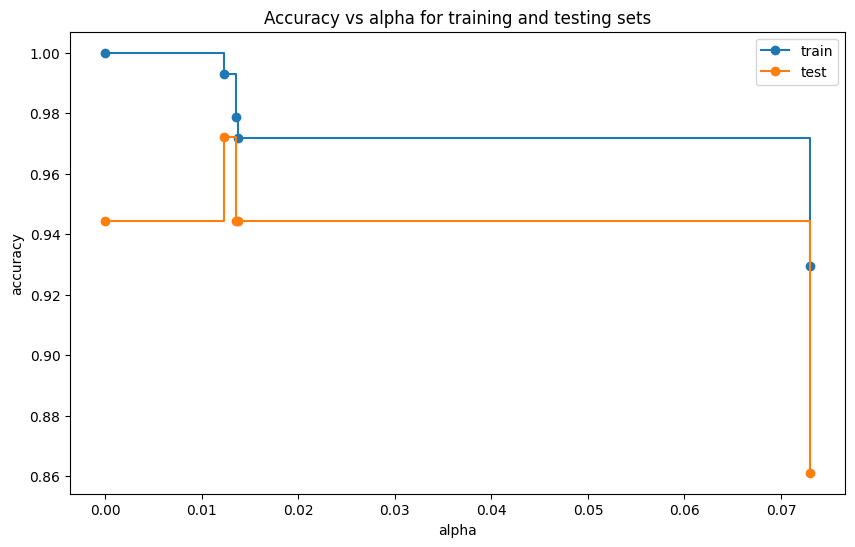

In [16]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
# n_splits = 10
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
cv = LeaveOneOut()

# Решающее дерево с cost-complexity pruning + кросс-валидация
tree_param_grid = {
    "ccp_alpha": ccp_alphas,
    "max_depth": [None, 3, 5, 7, 9],
    "min_samples_leaf": [1, 2, 5, 10]
}

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_grid = GridSearchCV(
    estimator=tree,
    param_grid=tree_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)
tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_

In [ ]:
# Лучшие параметры
tree_grid.best_params_

{'ccp_alpha': np.float64(0.013723365836041881),
 'max_depth': None,
 'min_samples_leaf': 1}

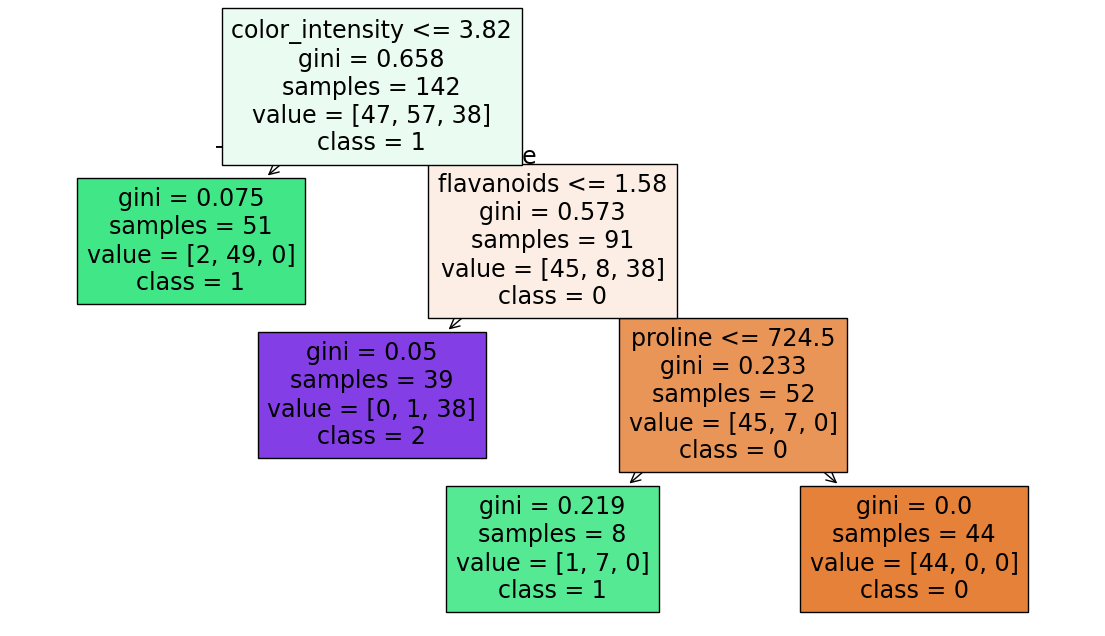

In [ ]:
# Визуализация дерева
fig, ax = plt.subplots(figsize=(14, 8))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(np.unique(y))],
    filled=True,
    ax=ax
)
plt.show()

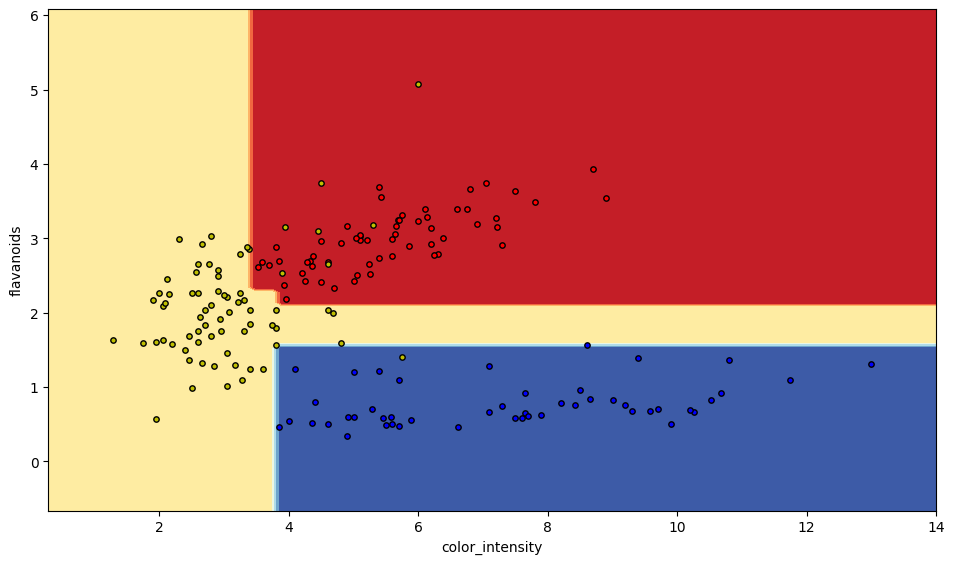

In [26]:
# Рисуем разделяющие гиперплоскости
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
clf = DecisionTreeClassifier(**tree_grid.best_params_).fit(X[["color_intensity", "flavanoids"]], y)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X[["color_intensity", "flavanoids"]],
    cmap=plt.cm.RdYlBu,
    response_method="predict",
    ax=ax,
    xlabel="color_intensity",
    ylabel="flavanoids",
)

# Добавляем точки
for i, color in zip(range(3), "ryb"):
    idx = np.asarray(y == i).nonzero()
    plt.scatter(
        X["color_intensity"].iloc[idx],
        X["flavanoids"].iloc[idx],
        c=color,
        label=[0, 1, 2],
        edgecolor="black",
        s=15,
    )

In [ ]:
# Случайный лес
# TODO: подбор гиперпараметров
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Градиентный бустинг
# TODO: рассмотреть catboost или xgboost? Добавить подбор гиперпараметров (кроме n_estimators?), визуализация зависимости cross_val_score от количества деревьев (нарисовать вместе со случайным лесом?)
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)
gb_cv_scores = cross_val_score(
    gb, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
)
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


=== Кросс-валидация ===
DecisionTree (GridSearchCV по ccp_alpha): best params = {'ccp_alpha': np.float64(0.013723365836041881), 'max_depth': None, 'min_samples_leaf': 1}, best CV accuracy = 0.9296
RandomForest: CV accuracy = 0.9789 ± 0.0216
GradientBoosting: CV accuracy = 0.9577 ± 0.0302

=== Тестовая выборка ===
               Модель  Accuracy (test)
         RandomForest         1.000000
DecisionTree (pruned)         0.944444
     GradientBoosting         0.944444

Лучшая модель на тесте: RandomForest
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     1.0000    1.0000    1.0000        14
           2     1.0000    1.0000    1.0000        10

    accuracy                         1.0000        36
   macro avg     1.0000    1.0000    1.0000        36
weighted avg     1.0000    1.0000    1.0000        36



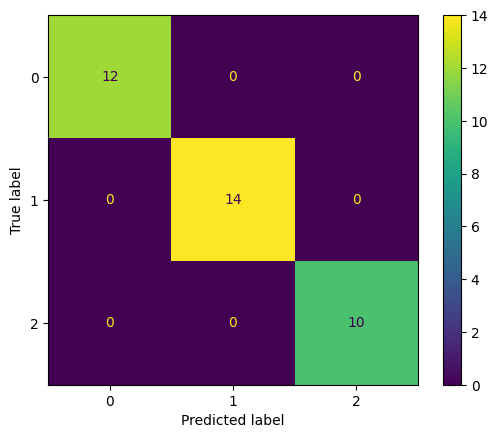

In [ ]:
# Оценка качества моделей
n_splits = X.shape[0]
models = {
    "DecisionTree (pruned)": best_tree,
    "RandomForest": rf,
    "GradientBoosting": gb
}

rows = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rows.append((name, acc))

summary = pd.DataFrame(rows, columns=["Модель", "Accuracy (test)"]).sort_values(
    "Accuracy (test)", ascending=False
)

print("=== Кросс-валидация ===")
print(f"DecisionTree (GridSearchCV по ccp_alpha): best params = {tree_grid.best_params_}, best CV accuracy = {tree_grid.best_score_:.4f}")
print(f"RandomForest: CV accuracy = {rf_cv_scores.mean():.4f} ± {2 * rf_cv_scores.std() / np.sqrt(n_splits):.4f}")
print(f"GradientBoosting: CV accuracy = {gb_cv_scores.mean():.4f} ± {2 * gb_cv_scores.std() / np.sqrt(n_splits):.4f}")

print("\n=== Тестовая выборка ===")
print(summary.to_string(index=False))

# Отчёт по лучшей модели
best_name = summary.iloc[0, 0]
best_model = models[best_name]
y_pred_best = best_model.predict(X_test)
print(f"\nЛучшая модель на тесте: {best_name}")
print(classification_report(y_test, y_pred_best, digits=4))

cm = confusion_matrix(y_test, y_pred_best)
cm_display = ConfusionMatrixDisplay(cm, display_labels = [0, 1, 2])
cm_display.plot()

plt.show()